# Project 1, Part 4, Holiday Analytics

University of California, Berkeley
Master of Information and Data Science (MIDS) program
w205 - Fundamentals of Data Engineering

Student: John (Jack) Galvin

Year: 2022

Semester: Spring

Section: 9


# Included Modules and Packages

Code cell containing your includes for modules and packages

In [96]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import psycopg2

# Supporting code

Code cells containing any supporting code, such as connecting to the database, any functions, etc.  Remember you can use any code from the labs.

In [2]:
# Function to run a select query and return rows in a pandas dataframe
# Pandas puts all numeric values from postgres to float
# If it will fit in an integer, change it to integer


def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)

In [3]:
# Connect to Postgres

connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

In [4]:
# Create a cursor for the connection

cursor = connection.cursor()

## How do holidays affect the sales, considering both the actual holiday, and the days before and after the holiday? 

## Create an executive summary explaining how holidays have affected sales. 

## You must support your summary with data, in the form of output of queries, data visualization, etc. There is a 1 query minimum.

# Assumptions

* Holidays under examination for analysis are all of the ones listed in the holidays table
* "Sales" will be analyzed with respect to daily revenue across all stores and daily quantity of meals sold across all stores

## Query 1 - Transaction Level Detail, USD

In [51]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select sale_date as date,
        total_amount as usd
from sales
order by sale_date

"""

df1 = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df1

,date,usd
0,2020-01-01,96
1,2020-01-01,144
2,2020-01-01,48
3,2020-01-01,24
4,2020-01-01,108
...,...,...
1537612,2020-12-31,60
1537613,2020-12-31,96
1537614,2020-12-31,60
1537615,2020-12-31,12


## Query 2 - Total Meals Sold, by Day

In [52]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select sa.sale_date as date,
        sum(l.quantity) as meals_sold
from sales as sa
    join line_items as l
        on sa.store_id = l.store_id and sa.sale_id = l.sale_id
group by date
order by date

"""

df2 = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df2

,date,meals_sold
0,2020-01-01,11148
1,2020-01-02,21760
2,2020-01-03,21923
3,2020-01-04,33364
4,2020-01-05,32916
...,...,...
359,2020-12-27,33008
360,2020-12-28,22071
361,2020-12-29,10870
362,2020-12-30,21952


## Query 3 - Holidays

In [53]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select *
from holidays

"""

df3 = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df3

,holiday_date,description,closed_flag
0,2020-01-01,New Year's Day,False
1,2020-01-20,MLK Day,False
2,2020-02-17,President's Day,False
3,2020-04-12,Easter,False
4,2020-05-10,Mother's Day,False
5,2020-05-25,Memorial Day,False
6,2020-06-21,Father's Day,False
7,2020-07-04,Independence Day,False
8,2020-09-07,Labor Day,False
9,2020-11-11,Veterans Days,False


# Merge Data Frames

In [54]:
# Roll df1 up to daily and set the index as date

df1["date"] = pd.to_datetime(df1["date"])
df1 = pd.DataFrame(df1.groupby("date")["usd"].sum())
df1

,usd
date,
2020-01-01,133776
2020-01-02,261120
2020-01-03,263076
2020-01-04,400368
2020-01-05,394992
...,...
2020-12-27,396096
2020-12-28,264852
2020-12-29,130440


In [55]:
# Set the index as date in df2 and df3

df2["date"] = pd.to_datetime(df2["date"])
df3["holiday_date"] = pd.to_datetime(df3["holiday_date"])

df2.set_index("date", inplace=True)
df3.set_index("holiday_date", inplace=True)

In [63]:
# Merge df1 and df2

df = df1.join(df2)

In [84]:
# Merge df3

df = df.join(df3, how="outer")

# Data Manipulation and Feature Extraction

In [121]:
# Fill NaN for usd and meals_sold (Thanksgiving and Christmas)

df["usd"].fillna(0, inplace=True)
df["meals_sold"].fillna(0, inplace=True)

In [136]:
# Create a new column as a holiday indicator

df["is_holiday"] = np.where(df["description"].isna() == True, 0, 1)

In [155]:
# Create several columns for rolling sums of usd (previous n days)
df["past_2_usd"] = df["usd"].rolling(window = 2).apply(sum)
df["past_3_usd"] = df["usd"].rolling(window = 3).apply(sum)
df["past_4_usd"] = df["usd"].rolling(window = 4).apply(sum)
df["past_5_usd"] = df["usd"].rolling(window = 5).apply(sum)
df["past_6_usd"] = df["usd"].rolling(window = 6).apply(sum)
df["past_7_usd"] = df["usd"].rolling(window = 7).apply(sum)

# Create several columns for rolling sums of meals_sold (previous n days)
df["past_2_meals"] = df["meals_sold"].rolling(window = 2).apply(sum)
df["past_3_meals"] = df["meals_sold"].rolling(window = 3).apply(sum)
df["past_4_meals"] = df["meals_sold"].rolling(window = 4).apply(sum)
df["past_5_meals"] = df["meals_sold"].rolling(window = 5).apply(sum)
df["past_6_meals"] = df["meals_sold"].rolling(window = 6).apply(sum)
df["past_7_meals"] = df["meals_sold"].rolling(window = 7).apply(sum)

# Create several columns for the sums of sales (usd) for next n days
df["next_2_usd"] = df["usd"].rolling(2).sum().shift(-2)
df["next_3_usd"] = df["usd"].rolling(3).sum().shift(-3)
df["next_4_usd"] = df["usd"].rolling(4).sum().shift(-4)
df["next_5_usd"] = df["usd"].rolling(5).sum().shift(-5)
df["next_6_usd"] = df["usd"].rolling(6).sum().shift(-6)
df["next_7_usd"] = df["usd"].rolling(7).sum().shift(-7)

# Create several columns for the sums of meals_sold for next n days
df["next_2_meals"] = df["meals_sold"].rolling(2).sum().shift(-2)
df["next_3_meals"] = df["meals_sold"].rolling(3).sum().shift(-3)
df["next_4_meals"] = df["meals_sold"].rolling(4).sum().shift(-4)
df["next_5_meals"] = df["meals_sold"].rolling(5).sum().shift(-5)
df["next_6_meals"] = df["meals_sold"].rolling(6).sum().shift(-6)
df["next_7_meals"] = df["meals_sold"].rolling(7).sum().shift(-7)

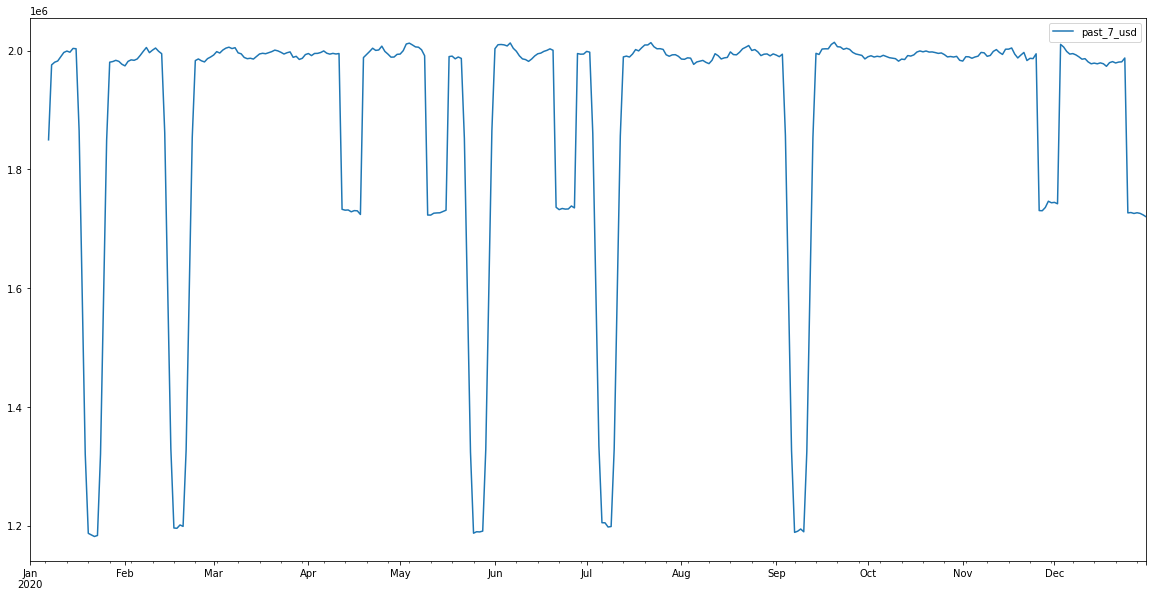

In [164]:
df.plot(y="past_7_usd", use_index=True, figsize=(20,10));

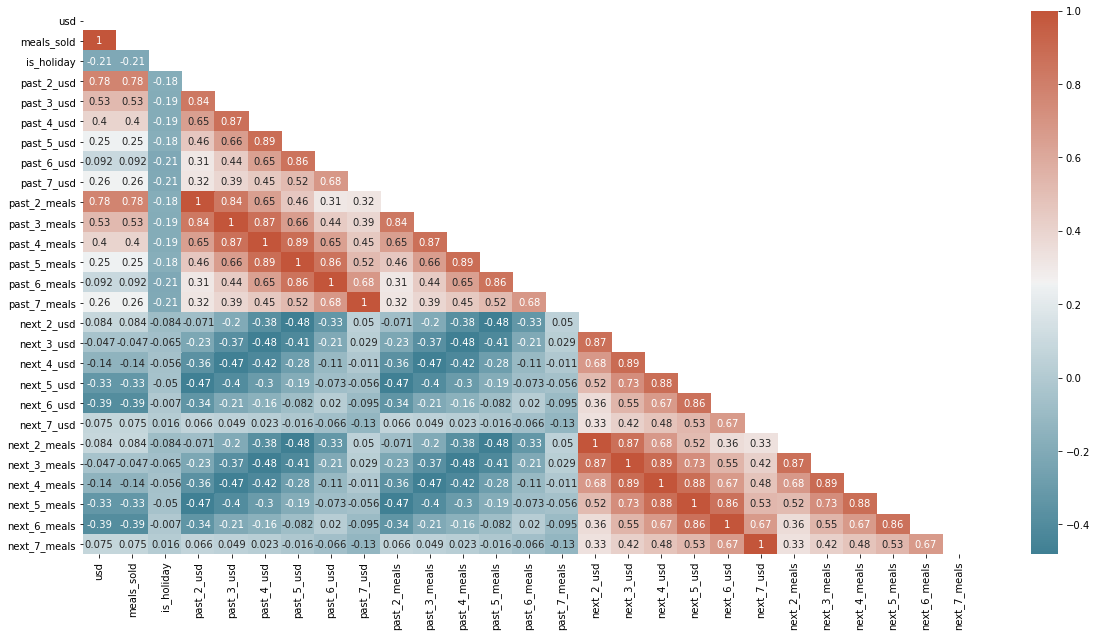

In [166]:
corr = df.corr("spearman")
matrix = np.triu(corr)
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, annot=True, mask=matrix, cmap = sns.diverging_palette(220,20, as_cmap=True), ax=ax)
pass

is_holiday
False    22896.508475
True     10243.333333
Name: meals_sold, dtype: Float64